# 0. Exploratory data analysis

We explore the Exoplanet Archive:
- Select properties
- Investigate missing rates
- Draw pairplots
- Compare old and new datasets
- Locate nearest neighbors

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import normalization
from knnxkde import select_givers, select_receivers
from knnxkde import nan_std_euclidean_distances

In [2]:
colnames = ['idx', 'pl_name', 'pl_radj', 'pl_bmassj', 'pl_orbper', 'pl_teq', 'pl_pnum', 'st_mass']
all_planets = pd.read_csv('data/NEA_radmasstpersmasspnum.csv', names=colnames, sep=',', skiprows=1)
names_tlg2020 = all_planets['pl_name']

In [3]:
original_df = pd.read_csv('data/exoplanets2023.csv')

In [4]:
my_df = original_df.copy()
for n in range(len(my_df)):
    if my_df.loc[n, 'pl_bmassprov'] == 'Msini':
        my_df.loc[n, 'pl_bmassj'] = np.nan
    if my_df.loc[n, 'pl_orbeccen']<0.0:
        my_df.loc[n, 'pl_orbeccen'] = 0  # Remove the 3 suspicious values 

In [5]:
ALL_FEATURES = [
    'pl_radj',
    'pl_bmassj',
    'pl_orbper',
    'pl_orbeccen',
    'pl_orbincl',
    'pl_eqt',
    'st_mass',
    'st_met',
    'st_age',
    'sy_snum',
    'sy_pnum'
]

In [6]:
TLG2020_FEATURES = [
    'pl_radj',
    'pl_bmassj',
    'pl_orbper',
    'pl_eqt',
    'st_mass',
    'sy_pnum',
]

In [7]:
NEW_FEATURES = [
    'pl_radj',
    'pl_bmassj',
    'pl_orbper',
    'pl_orbeccen',
    'pl_eqt',
    'st_mass',
    'st_met',
    'sy_pnum',
]

In [8]:
for f in ALL_FEATURES:
    mini = np.nanmin(my_df[f])
    maxi = np.nanmax(my_df[f])
    mr = np.mean(np.isnan(my_df[f]))  # miss rate
    print(f'{f} -> min={mini}, max={maxi}, mr={mr:0.2%}')

pl_radj -> min=0.026, max=6.9, mr=30.39%
pl_bmassj -> min=6e-05, max=31.0, mr=72.84%
pl_orbper -> min=0.09070629, max=402000000.0, mr=3.71%
pl_orbeccen -> min=0.0, max=0.95, mr=70.14%
pl_orbincl -> min=7.7, max=176.092, mr=71.38%
pl_eqt -> min=48.37660541, max=7719.403614, mr=13.52%
st_mass -> min=0.01, max=10.94, mr=0.51%
st_met -> min=-1.0, max=0.56, mr=10.15%
st_age -> min=0.001, max=14.9, mr=26.49%
sy_snum -> min=1, max=4, mr=0.00%
sy_pnum -> min=1, max=8, mr=0.00%


In [9]:
from scipy.special import softmax

def locate_nearest_neighbours(X, planet_idx, hide_values, nb_neigh=20):
    miss_data = np.copy(X)
    miss_data[planet_idx, hide_values] = np.nan
    norm_miss_data, norm_params = normalization(miss_data)
    
    sigmas = np.nanstd(norm_miss_data, axis=0)
    current_miss_pattern = np.isnan(norm_miss_data[idx])
    
    id_receivers = select_receivers(norm_miss_data, current_miss_pattern)
    id_givers = select_givers(miss_data, current_miss_pattern)
    data_receivers = norm_miss_data[id_receivers]
    data_givers = norm_miss_data[id_givers]
    
    d_ij = nan_std_euclidean_distances(data_receivers, data_givers, sigmas)
    p_ij = softmax(- 50.0 * d_ij, axis=1)
    ii = np.where(id_receivers==idx)[0][0]
    neighbours = np.argsort(d_ij[ii])[:nb_neigh]
    
    #print(id_givers[neighbours])
    #print(original_df.iloc[id_givers[neighbours]])
    #print(d_ij[ii][neighbours])
    #print(p_ij[ii][neighbours]*100.0)
    #print((p_ij[ii][neighbours]*100.0).sum())
    #print((p_ij[ii][neighbours] / p_ij[ii][neighbours].sum())*100.0)
    
    return id_givers[neighbours]

## $6\times6$ Pairplot

Pairplots are used to understand several distributions:  
(i) Overall demographics (in black/grey dots)  
(ii) Where a specific planet sits in the multidimensional space (in red)  
(iii) Where are the nearest neighbors (in orange)  

In [10]:
X = np.array(my_df[TLG2020_FEATURES])
X[:, [0, 1, 2, 3, 4]] = np.log(X[:, [0, 1, 2, 3, 4]])
X_df = pd.DataFrame(X, columns=TLG2020_FEATURES)

mask_tlg2020 = np.zeros(X_df.shape[0], dtype=bool)
for n in range(X_df.shape[0]):
    cur_name = original_df.iloc[n]['pl_name']
    if cur_name in list(names_tlg2020):
        mask_tlg2020[n] = True

X_df_tlg2020 = X_df.iloc[mask_tlg2020]
X_df_other = X_df.iloc[~mask_tlg2020]
print(X_df.shape)
print(X_df_tlg2020.shape)
print(X_df_other.shape)

(5251, 6)
(547, 6)
(4704, 6)


In [11]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses

SUPER_LIST = []
for n1 in range(-3, 9):
    for n2 in range(1, 10):
        exec(f'val = {n2}e{n1}')
        SUPER_LIST.append(val)

MY_BINS_NB_PLANETS = [0.8, 1.2, 1.8, 2.2, 2.8, 3.2, 3.8, 4.2, 4.8, 5.2, 5.8, 6.2, 6.8, 7.2, 7.8, 8.2]

MY_LABELS = [
    'Planet radius [r$_\oplus$]',
    'Planet mass [m$_\oplus$]',
    'Orbital period [days]',
    'Planet Eq. Temp. [K]',
    'Star mass [m$_\odot$]',
    'Nb of planets',
]

MY_TICKLABELS = [
    ['$10^0$', '$10^1$'],  # for planet radius
    ['$10^{-1}$', '$10^0$', '$10^1$', '$10^2$', '$10^3$'],  # for planet mass
    ['$10^0$', '$10^2$', '$10^4$', '$10^6$', '$10^8$'],  # for orbital period
    ['$10^2$', '$10^3$'],  # for pl_teq
    ['$10^{-2}$', '$10^{-1}$', '$10^0$', '$10^1$'],  # for star mass
    ['$1$', '$2$', '$3$', '$4$', '$5$', '$6$', '$7$', '$8$'],  # for number of planets
]

MY_MINOR_TICKLABELS = [
    SUPER_LIST[20:46],  # for radius: 0.3 ~ 100.0 Earth radii
    SUPER_LIST[10:65],  # for mass: 0.02 ~ 20,000 Earth masses
    SUPER_LIST[15:104],  # for orbital period: 0.07 ~ 500,000,000 days
    SUPER_LIST[38:64],  # for planet t_eq: 30 ~ 10,000 K
    SUPER_LIST[5:37],  # for star mass: 0.006 ~ 10.0 solar masses
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # for number of planets
]

MY_TICKS = [
    np.log(np.array([1e0, 1e1])/RJ),  # planet radius
    np.log(np.array([1e-1, 1e0, 1e1, 1e2, 1e3])/MJ),  # planet mass
    np.log(np.array([1e0, 1e2, 1e4, 1e6, 1e8])),  # orbital period
    np.log(np.array([1e2, 1e3])),  # planet teq
    np.log(np.array([1e-2, 1e-1, 1e0, 1e1])),  # star mass
    np.array([1, 2, 3, 4, 5, 6, 7, 8]),  # star mass
]

MY_MINOR_TICKS = [
    np.log(np.array(MY_MINOR_TICKLABELS[0])/RJ),
    np.log(np.array(MY_MINOR_TICKLABELS[1])/MJ),
    np.log(np.array(MY_MINOR_TICKLABELS[2])),
    np.log(np.array(MY_MINOR_TICKLABELS[3])),
    np.log(np.array(MY_MINOR_TICKLABELS[4])),
    np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
]

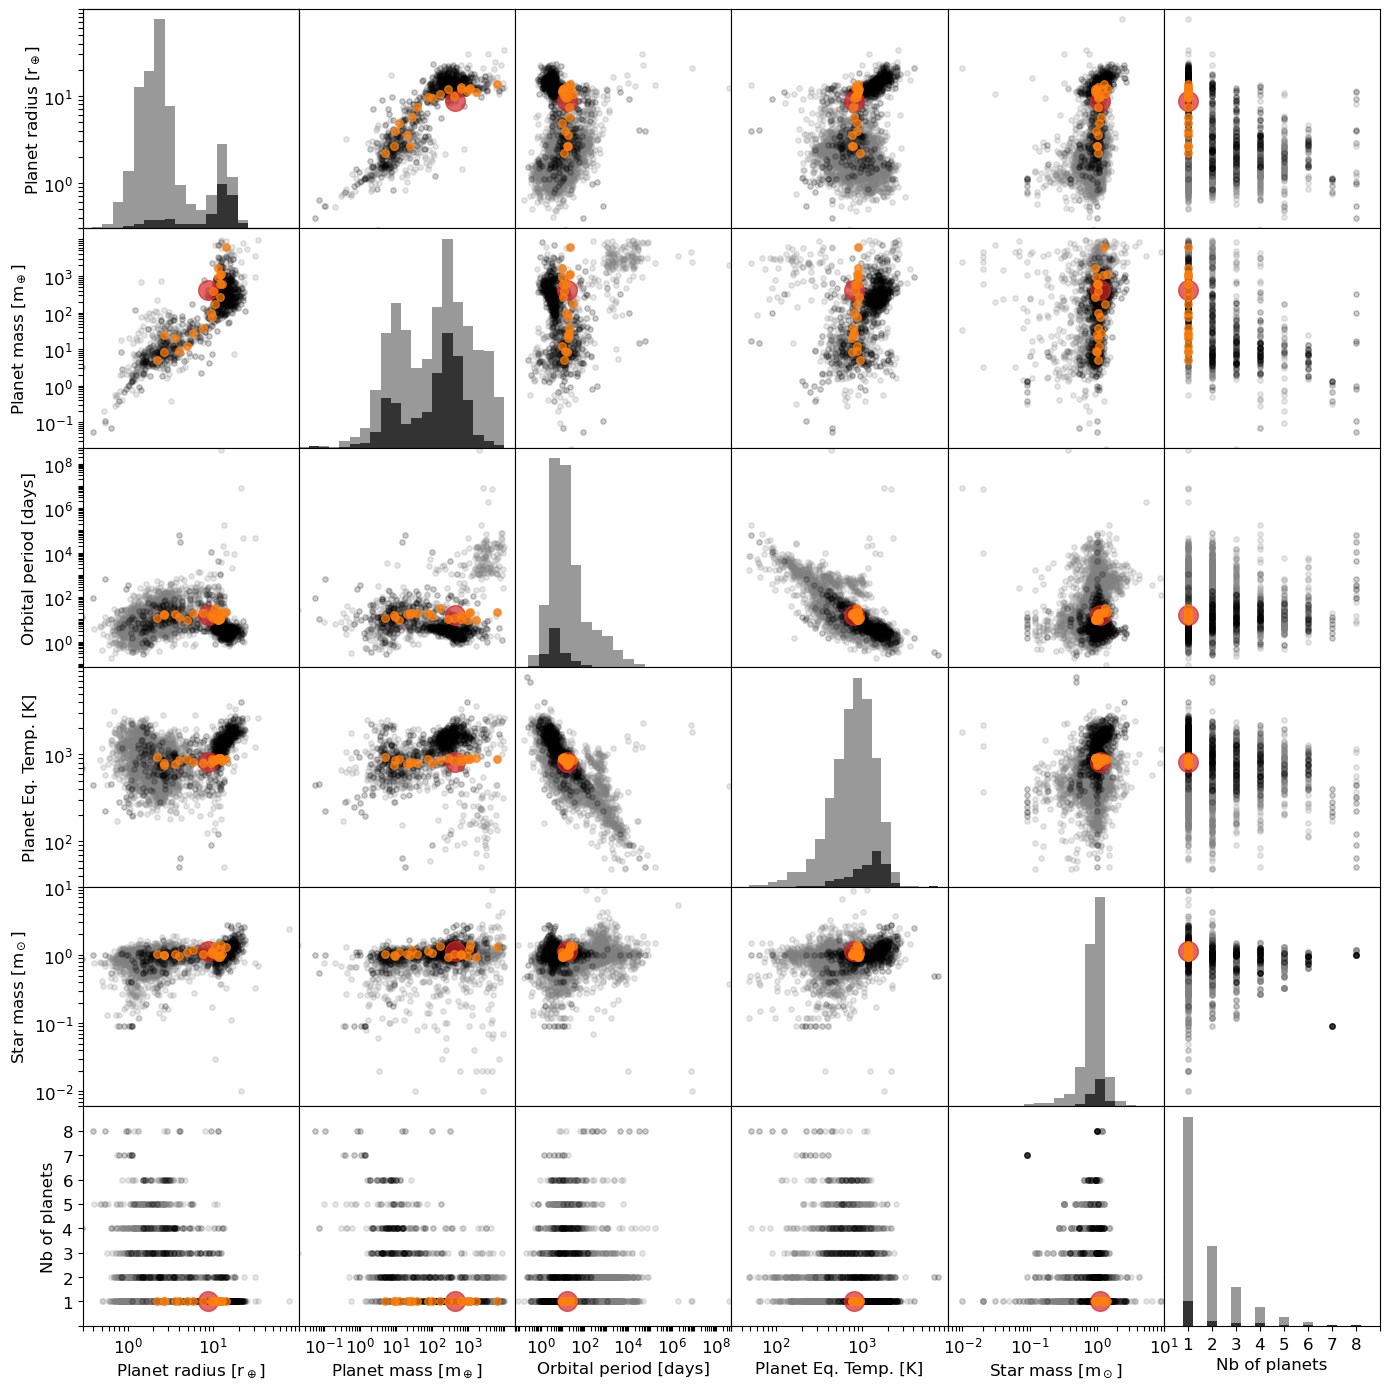

In [30]:
SELECT_PLANET = 'HATS-17 b'
mask = (original_df['pl_name'] == SELECT_PLANET)
idx = np.where(mask)[0][0]
neigh_idx = locate_nearest_neighbours(X, planet_idx=idx, hide_values=[0, 1], nb_neigh=20)

fig, ax = plt.subplots(6, 6, figsize=(14, 14), gridspec_kw={'wspace':0, 'hspace':0})
for n1 in range(6):
    for n2 in range(6):
        if n1==n2:
            if n1==5:
                temp = [X_df_tlg2020.iloc[:, n1], X_df_other.iloc[:, n1]]
                ax[n1][n2].hist(temp, bins=MY_BINS_NB_PLANETS, color=['black', 'grey'], stacked=True, alpha=0.8, rasterized=True)
            else:
                temp = [X_df_tlg2020.iloc[:, n1], X_df_other.iloc[:, n1]]
                ax[n1][n2].hist(temp, bins=20, color=['black', 'grey'], stacked=True, alpha=0.8, rasterized=True)
            ax[n1][n2].set_xlim(MY_MINOR_TICKS[n1][0], MY_MINOR_TICKS[n1][-1])
        else:
            ax[n1][n2].scatter(X_df_other.iloc[:, n2], X_df_other.iloc[:, n1], c='grey', s=15, alpha=0.2, rasterized=True)
            ax[n1][n2].scatter(X_df_tlg2020.iloc[:, n2], X_df_tlg2020.iloc[:, n1], c='black', s=15, alpha=0.2, rasterized=True)
            ax[n1][n2].scatter(X_df.iloc[idx, n2], X_df.iloc[idx, n1], c='C3', s=200, alpha=0.7, rasterized=True)
            for i in neigh_idx:
                ax[n1][n2].scatter(X_df.iloc[i, n2], X_df.iloc[i, n1], c='C1', s=30, alpha=0.7, rasterized=True)
            ax[n1][n2].set_xlim(MY_MINOR_TICKS[n2][0], MY_MINOR_TICKS[n2][-1])
            ax[n1][n2].set_ylim(MY_MINOR_TICKS[n1][0], MY_MINOR_TICKS[n1][-1])
        if n1==5 and n2==0:
            ax[n1][n2].set_xticks(MY_TICKS[n2], MY_TICKLABELS[n2], size=12, minor=False)
            ax[n1][n2].set_yticks(MY_TICKS[n1], MY_TICKLABELS[n1], size=12, minor=False)
            ax[n1][n2].set_xticks(MY_MINOR_TICKS[n2], minor=False)
            ax[n1][n2].set_yticks(MY_MINOR_TICKS[n1], minor=False)
            ax[n1][n2].set_xlabel(MY_LABELS[n2], size=12)
            ax[n1][n2].set_ylabel(MY_LABELS[n1], size=12)
        elif n1==5:
            ax[n1][n2].set_xticks(MY_TICKS[n2], MY_TICKLABELS[n2], size=12, minor=False)
            ax[n1][n2].set_xticks(MY_MINOR_TICKS[n2], minor=False)
            ax[n1][n2].set_yticks([])
            ax[n1][n2].set_xlabel(MY_LABELS[n2], size=12)
        elif n2==0:
            if n1==0:
                ax[n1][n2].set_yticks([])
                temp = ax[n1][n2].twinx()
                temp.set_yticks(MY_TICKS[n1], MY_TICKLABELS[n1], size=12, minor=False)
                temp.set_yticks(MY_MINOR_TICKS[n1], minor=False)
                ax[n1][n2].set_ylabel('Planet radius [r$_\oplus$]\n\n', size=12)
                temp.yaxis.tick_left()
            else:
                ax[n1][n2].set_yticks(MY_TICKS[n1], MY_TICKLABELS[n1], size=12, minor=False)
                ax[n1][n2].set_yticks(MY_MINOR_TICKS[n1], minor=False)
                ax[n1][n2].set_ylabel(MY_LABELS[n1], size=12)
            ax[n1][n2].set_xticks([])
        else:
            ax[n1][n2].set_xticks([])
            ax[n1][n2].set_yticks([])
fig.tight_layout()
plt.savefig(f'results_and_figures/selected_planets/{SELECT_PLANET}_pairplot6_neighbours20.pdf', dpi=150)
plt.show()

## $8 \times 8$ Pairplot

In [36]:
X6 = np.array(my_df[TLG2020_FEATURES])
X6[:, [0, 1, 2, 3, 4]] = np.log(X6[:, [0, 1, 2, 3, 4]])
X6_df = pd.DataFrame(X6, columns=TLG2020_FEATURES)

X8 = np.array(my_df[NEW_FEATURES])
X8[:, [0, 1, 2, 4, 5]] = np.log(X8[:, [0, 1, 2, 4, 5]])
X_df = pd.DataFrame(X8, columns=NEW_FEATURES)

mask_tlg2020 = np.zeros(X_df.shape[0], dtype=bool)
for n in range(X_df.shape[0]):
    cur_name = original_df.iloc[n]['pl_name']
    if cur_name in list(names_tlg2020):
        mask_tlg2020[n] = True

#mask_tlg2020 = np.zeros(X_df.shape[0], dtype=bool)
#for n in range(X_df.shape[0]):
#    if not pd.isna(X_df.iloc[n, [0, 1, 2, 4, 5, 7]]).any():
#        mask_tlg2020[n] = True

X_df_tlg2020 = X_df.iloc[mask_tlg2020]
X_df_other = X_df.iloc[~mask_tlg2020]
print(X_df.shape)
print(X_df_tlg2020.shape)
print(X_df_other.shape)

(5251, 8)
(547, 8)
(4704, 8)


In [37]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses

SUPER_LIST = []
for n1 in range(-3, 9):
    for n2 in range(1, 10):
        exec(f'val = {n2}e{n1}')
        SUPER_LIST.append(val)

MY_BINS_NB_PLANETS = [0.8, 1.2, 1.8, 2.2, 2.8, 3.2, 3.8, 4.2, 4.8, 5.2, 5.8, 6.2, 6.8, 7.2, 7.8, 8.2]

MY_LABELS = [
    'Planet radius [r$_\oplus$]',
    'Planet mass [m$_\oplus$]',
    'Orbital period [days]',
    'Orbital ecc.',
    'Planet Eq. Temp. [K]',
    'Star mass [m$_\odot$]',
    'Star metal. [dex]',
    'Nb of planets',
]

MY_TICKLABELS = [
    ['$10^0$', '$10^1$'],  # for planet radius
    ['$10^{-1}$', '$10^0$', '$10^1$', '$10^2$', '$10^3$'],  # for planet mass
    ['$10^0$', '$10^2$', '$10^4$', '$10^6$', '$10^8$'],  # for orbital period
    ['$0.25$', '$0.5$', '$0.75$', '$1.0$'],  # for orbital ecc.
    ['$10^2$', '$10^3$'],  # for pl_teq
    ['$10^{-2}$', '$10^{-1}$', '$10^0$', '$10^1$'],  # for star mass
    ['$-1.0$', '$-0.5$', '$0.0$', '$0.5$'],  # for star metal.
    ['$1$', '$2$', '$3$', '$4$', '$5$', '$6$', '$7$', '$8$'],  # for number of planets
]

MY_MINOR_TICKLABELS = [
    SUPER_LIST[20:46],  # for radius: 0.3 ~ 100.0 Earth radii
    SUPER_LIST[10:65],  # for mass: 0.02 ~ 20,000 Earth masses
    SUPER_LIST[15:104],  # for orbital period: 0.07 ~ 500,000,000 days
    [-0.02, 0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0],  # for orbital ecc.: 0.00 ~ 1.00 days
    SUPER_LIST[38:64],  # for planet t_eq: 30 ~ 10,000 K
    SUPER_LIST[5:37],  # for star mass: 0.006 ~ 10.0 solar masses
    [-1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6],  # for star metal.: -1.2 ~ 0.6 dex
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # for number of planets
]

MY_TICKS = [
    np.log(np.array([1e0, 1e1])/RJ),  # planet radius
    np.log(np.array([1e-1, 1e0, 1e1, 1e2, 1e3])/MJ),  # planet mass
    np.log(np.array([1e0, 1e2, 1e4, 1e6, 1e8])),  # orbital period
    np.array([0.25, 0.5, 0.75, 1.0]),  # orbital ecc.
    np.log(np.array([1e2, 1e3])),  # planet teq
    np.log(np.array([1e-2, 1e-1, 1e0, 1e1])),  # star mass
    np.array([-1.0, -0.5, 0.0, 0.5]),  # star met
    np.array([1, 2, 3, 4, 5, 6, 7, 8]),  # nb planets
]

MY_MINOR_TICKS = [
    np.log(np.array(MY_MINOR_TICKLABELS[0])/RJ),
    np.log(np.array(MY_MINOR_TICKLABELS[1])/MJ),
    np.log(np.array(MY_MINOR_TICKLABELS[2])),
    np.array(MY_MINOR_TICKLABELS[3]),
    np.log(np.array(MY_MINOR_TICKLABELS[4])),
    np.log(np.array(MY_MINOR_TICKLABELS[5])),
    np.array(MY_MINOR_TICKLABELS[6]),
    np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
]

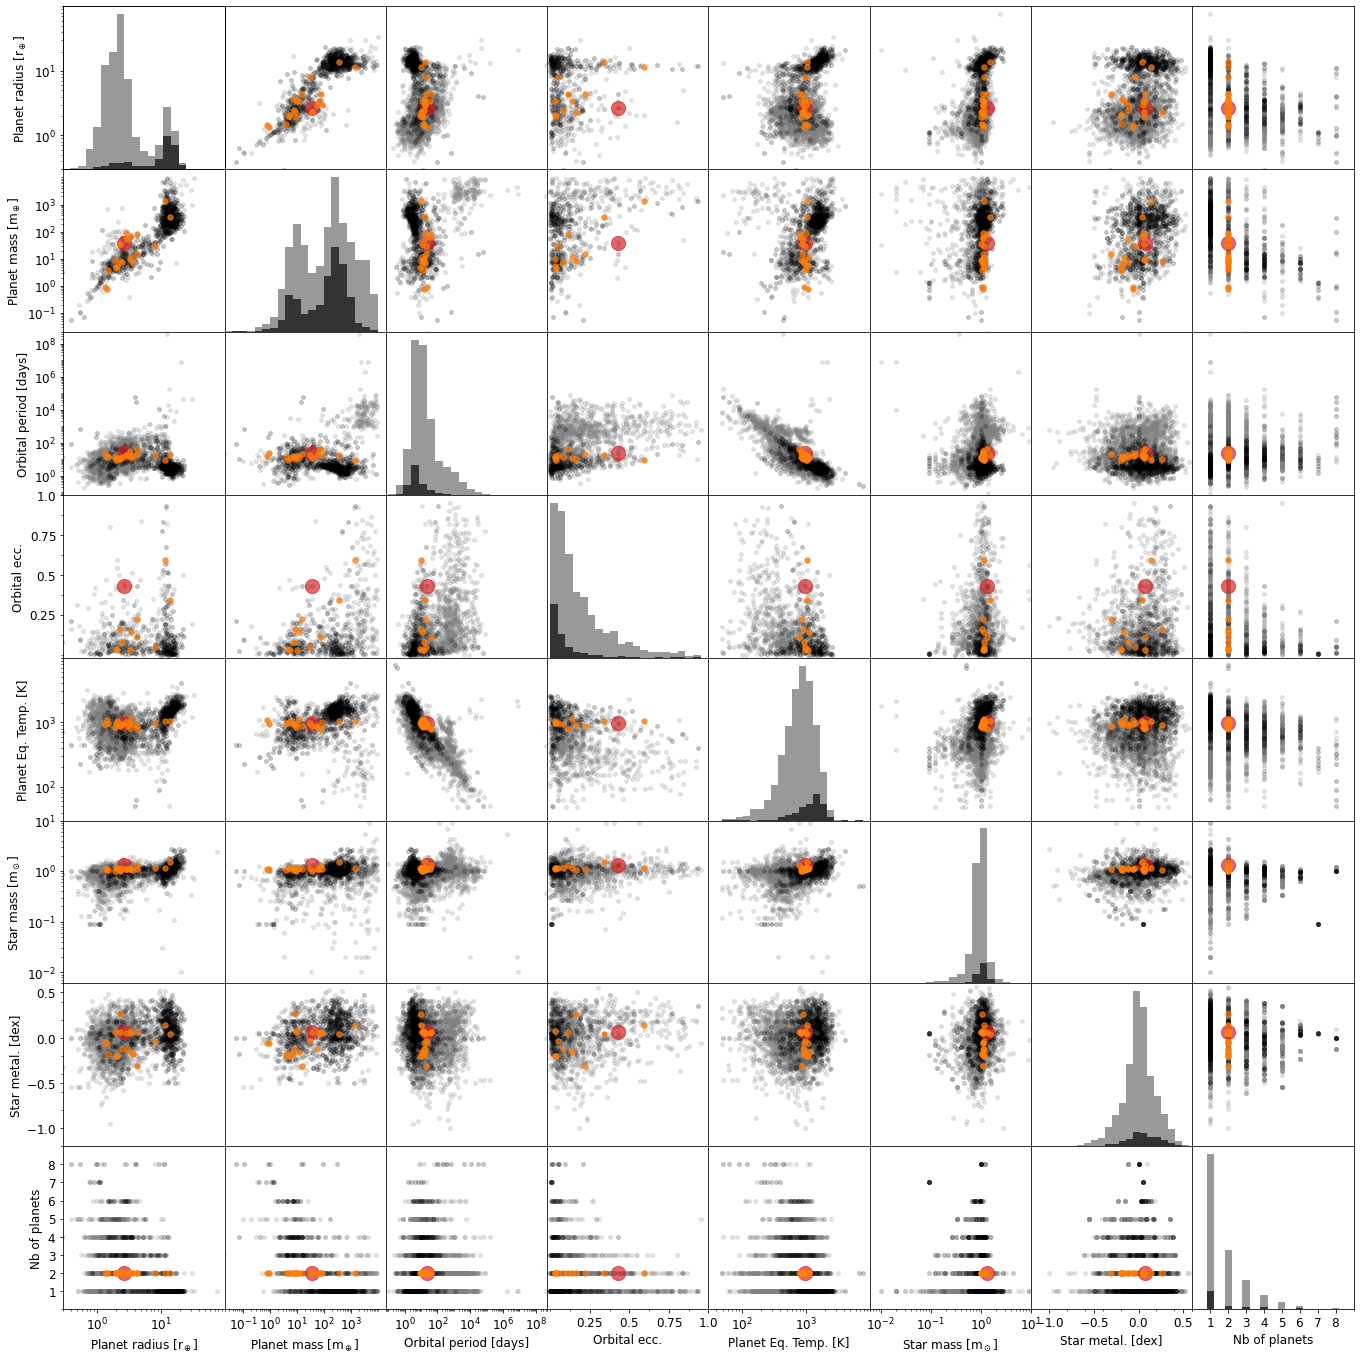

In [45]:
SELECT_PLANET = 'Kepler-145 b'
mask = (original_df['pl_name'] == SELECT_PLANET)
idx = np.where(mask)[0][0]
neigh_idx = locate_nearest_neighbours(X6, planet_idx=idx, hide_values=[0, 1], nb_neigh=20)

fig, ax = plt.subplots(8, 8, figsize=(19, 19), gridspec_kw={'wspace':0, 'hspace':0})
for n1 in range(8):
    for n2 in range(8):
        if n1==n2:
            if n1==7:
                temp = [X_df_tlg2020.iloc[:, n1], X_df_other.iloc[:, n1]]
                ax[n1][n2].hist(temp, bins=MY_BINS_NB_PLANETS, color=['black', 'grey'], stacked=True, alpha=0.8, rasterized=True)
            else:
                temp = [X_df_tlg2020.iloc[:, n1], X_df_other.iloc[:, n1]]
                ax[n1][n2].hist(temp, bins=20, color=['black', 'grey'], stacked=True, alpha=0.8, rasterized=True)
            ax[n1][n2].set_xlim(MY_MINOR_TICKS[n1][0], MY_MINOR_TICKS[n1][-1])
        else:
            ax[n1][n2].scatter(X_df_other.iloc[:, n2], X_df_other.iloc[:, n1], c='grey', s=15, alpha=0.2, rasterized=True)
            ax[n1][n2].scatter(X_df_tlg2020.iloc[:, n2], X_df_tlg2020.iloc[:, n1], c='black', s=15, alpha=0.2, rasterized=True)
            ax[n1][n2].scatter(X_df.iloc[idx, n2], X_df.iloc[idx, n1], c='C3', s=200, alpha=0.7, rasterized=True)
            for i in neigh_idx:
                ax[n1][n2].scatter(X_df.iloc[i, n2], X_df.iloc[i, n1], c='C1', s=30, alpha=0.7, rasterized=True)
            ax[n1][n2].set_xlim(MY_MINOR_TICKS[n2][0], MY_MINOR_TICKS[n2][-1])
            ax[n1][n2].set_ylim(MY_MINOR_TICKS[n1][0], MY_MINOR_TICKS[n1][-1])
        if n1==7 and n2==0:
            ax[n1][n2].set_xticks(MY_TICKS[n2], MY_TICKLABELS[n2], size=12, minor=False)
            ax[n1][n2].set_yticks(MY_TICKS[n1], MY_TICKLABELS[n1], size=12, minor=False)
            ax[n1][n2].set_xticks(MY_MINOR_TICKS[n2], minor=True)
            ax[n1][n2].set_yticks(MY_MINOR_TICKS[n1], minor=True)
            ax[n1][n2].set_xlabel(MY_LABELS[n2], size=12)
            ax[n1][n2].set_ylabel(MY_LABELS[n1], size=12)
        elif n1==7:
            ax[n1][n2].set_xticks(MY_TICKS[n2], MY_TICKLABELS[n2], size=12, minor=False)
            ax[n1][n2].set_xticks(MY_MINOR_TICKS[n2], minor=True)
            ax[n1][n2].set_yticks([])
            ax[n1][n2].set_xlabel(MY_LABELS[n2], size=12)
        elif n2==0:
            if n1==0:
                ax[n1][n2].set_yticks([])
                temp = ax[n1][n2].twinx()
                temp.set_yticks(MY_TICKS[n1], MY_TICKLABELS[n1], size=12, minor=False)
                temp.set_yticks(MY_MINOR_TICKS[n1], minor=True)
                ax[n1][n2].set_ylabel('Planet radius [r$_\oplus$]\n\n', size=12)
                temp.yaxis.tick_left()
            else:
                ax[n1][n2].set_yticks(MY_TICKS[n1], MY_TICKLABELS[n1], size=12, minor=False)
                ax[n1][n2].set_yticks(MY_MINOR_TICKS[n1], minor=True)
                ax[n1][n2].set_ylabel(MY_LABELS[n1], size=12)
            ax[n1][n2].set_xticks([])
        else:
            ax[n1][n2].set_xticks([])
            ax[n1][n2].set_yticks([])
fig.tight_layout()
plt.savefig(f'results_and_figures/selected_planets/{SELECT_PLANET}_pairplot8_ButNeighbours6.pdf', dpi=150)
plt.show()

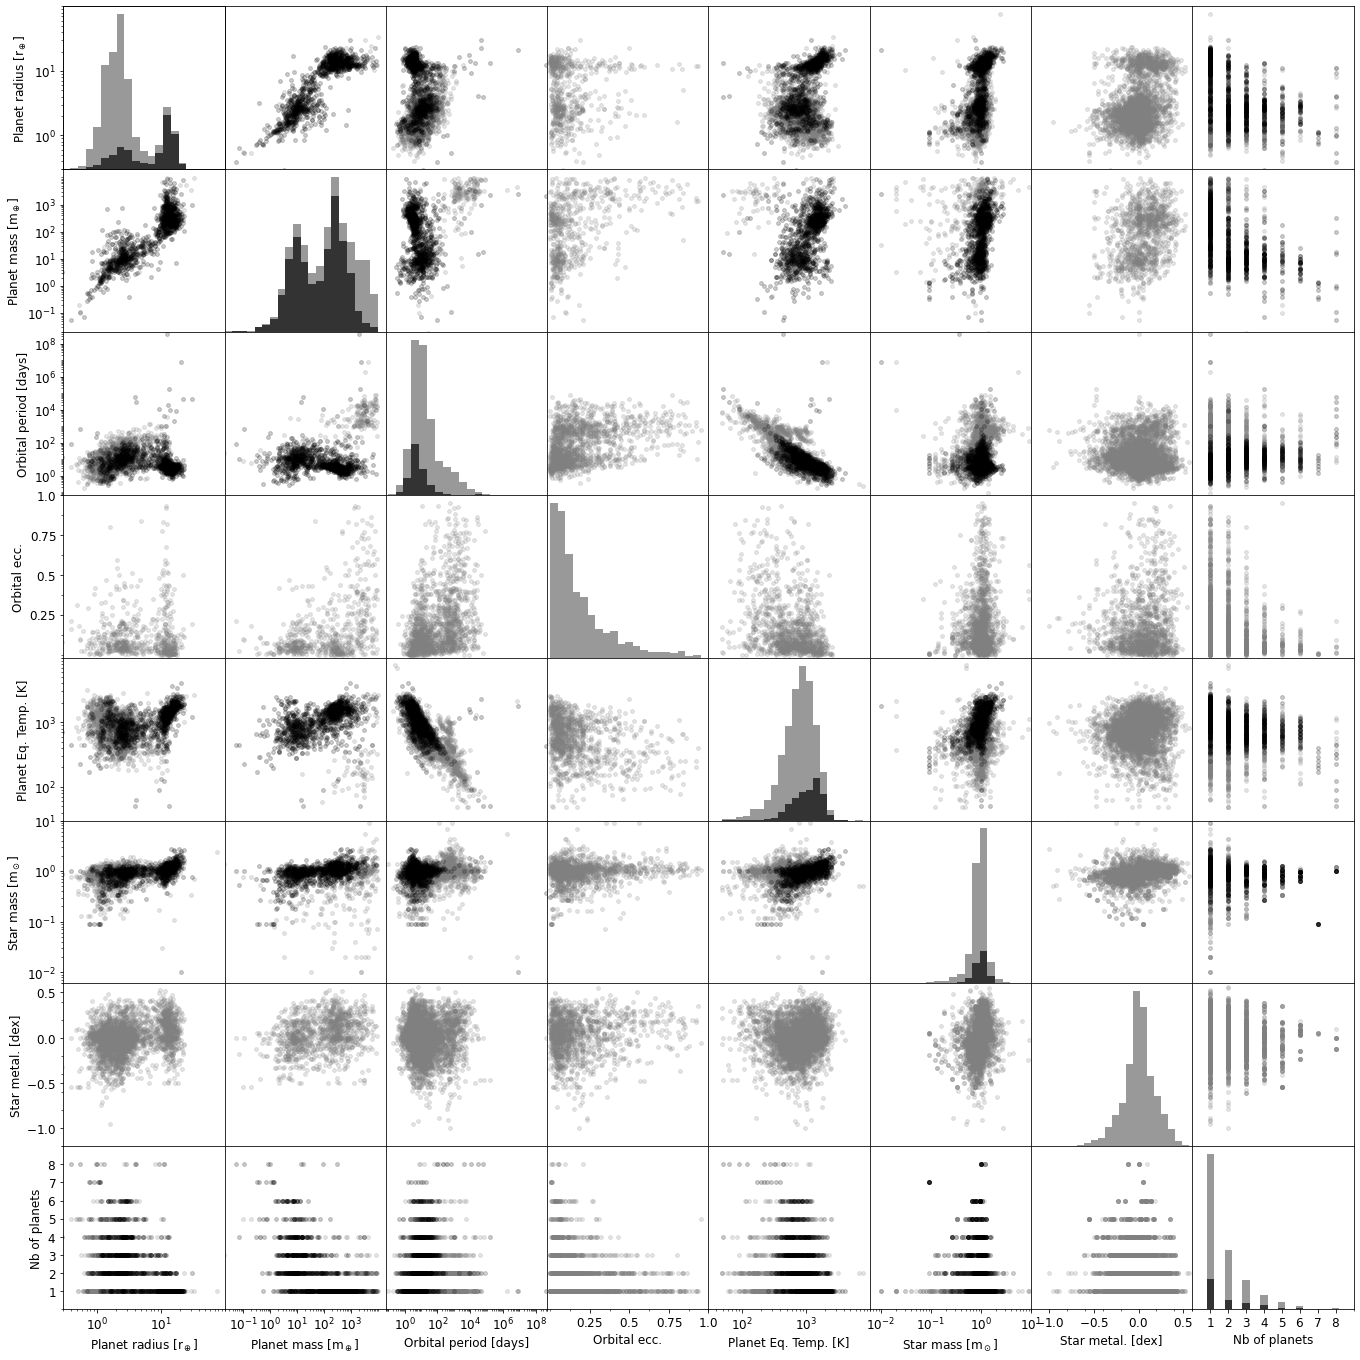

In [14]:
fig, ax = plt.subplots(8, 8, figsize=(19, 19), gridspec_kw={'wspace':0, 'hspace':0})
for n1 in range(8):
    for n2 in range(8):
        if n1==n2:
            if n1==7:
                temp = [X_df_tlg2020.iloc[:, n1], X_df_other.iloc[:, n1]]
                ax[n1][n2].hist(temp, bins=MY_BINS_NB_PLANETS, color=['black', 'grey'], stacked=True, alpha=0.8, rasterized=True)
            elif n1 in [0, 1, 2, 4, 5]:
                temp = [X_df_tlg2020.iloc[:, n1], X_df_other.iloc[:, n1]]
                ax[n1][n2].hist(temp, bins=20, color=['black', 'grey'], stacked=True, alpha=0.8, rasterized=True)
            elif n1 in [3, 6]:
                ax[n1][n2].hist(X_df.iloc[:, n1], bins=20, color='grey', alpha=0.8, rasterized=True)
            ax[n1][n2].set_xlim(MY_MINOR_TICKS[n1][0], MY_MINOR_TICKS[n1][-1])
        else:
            if (n1 in [3, 6]) or (n2 in [3, 6]):
                ax[n1][n2].scatter(X_df.iloc[:, n2], X_df.iloc[:, n1], c='grey', s=15, alpha=0.2, rasterized=True)
            else:
                ax[n1][n2].scatter(X_df_other.iloc[:, n2], X_df_other.iloc[:, n1], c='grey', s=15, alpha=0.2, rasterized=True)
                ax[n1][n2].scatter(X_df_tlg2020.iloc[:, n2], X_df_tlg2020.iloc[:, n1], c='black', s=15, alpha=0.2, rasterized=True)
            ax[n1][n2].set_xlim(MY_MINOR_TICKS[n2][0], MY_MINOR_TICKS[n2][-1])
            ax[n1][n2].set_ylim(MY_MINOR_TICKS[n1][0], MY_MINOR_TICKS[n1][-1])
        if n1==7 and n2==0:
            ax[n1][n2].set_xticks(MY_TICKS[n2], MY_TICKLABELS[n2], size=12, minor=False)
            ax[n1][n2].set_yticks(MY_TICKS[n1], MY_TICKLABELS[n1], size=12, minor=False)
            ax[n1][n2].set_xticks(MY_MINOR_TICKS[n2], minor=True)
            ax[n1][n2].set_yticks(MY_MINOR_TICKS[n1], minor=True)
            ax[n1][n2].set_xlabel(MY_LABELS[n2], size=12)
            ax[n1][n2].set_ylabel(MY_LABELS[n1], size=12)
        elif n1==7:
            ax[n1][n2].set_xticks(MY_TICKS[n2], MY_TICKLABELS[n2], size=12, minor=False)
            ax[n1][n2].set_xticks(MY_MINOR_TICKS[n2], minor=True)
            ax[n1][n2].set_yticks([])
            ax[n1][n2].set_xlabel(MY_LABELS[n2], size=12)
        elif n2==0:
            if n1==0:
                ax[n1][n2].set_yticks([])
                temp = ax[n1][n2].twinx()
                temp.set_yticks(MY_TICKS[n1], MY_TICKLABELS[n1], size=12, minor=False)
                temp.set_yticks(MY_MINOR_TICKS[n1], minor=True)
                ax[n1][n2].set_ylabel('Planet radius [r$_\oplus$]\n\n', size=12)
                temp.yaxis.tick_left()
            else:
                ax[n1][n2].set_yticks(MY_TICKS[n1], MY_TICKLABELS[n1], size=12, minor=False)
                ax[n1][n2].set_yticks(MY_MINOR_TICKS[n1], minor=True)
                ax[n1][n2].set_ylabel(MY_LABELS[n1], size=12)
            ax[n1][n2].set_xticks([])
        else:
            ax[n1][n2].set_xticks([])
            ax[n1][n2].set_yticks([])
fig.tight_layout()
plt.savefig(f'results_and_figures/final_8x8pairplot_with_new_complete2023.pdf', dpi=150)
plt.show()

## Compute Pearson and Spearman correlation coefficients

This will guide us towards potentially interesting dependencies beetween planet properties  
Pearson correlation coefficient captures linear dependency: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient  
Spearman correlation coefficient quantifies the rank correlation: https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient

In [12]:
corr_pearson = X_df.corr(method='pearson')
corr_spearman = X_df.corr(method='spearman')

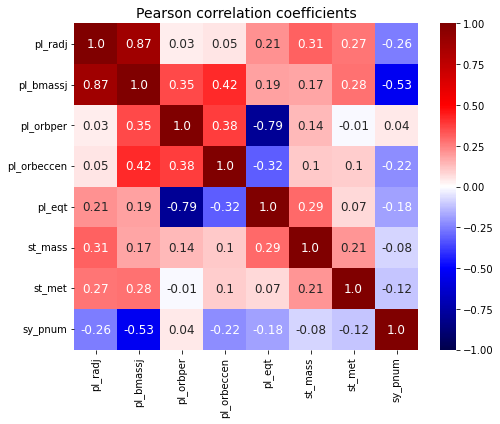

In [13]:
plt.figure(figsize=(7.2, 6))
sns.heatmap(
    corr_pearson,
    cmap = 'seismic',
    vmin = -1.0,
    vmax = 1.0,
    xticklabels = corr_pearson.columns.values,
    yticklabels = corr_pearson.columns.values,
    annot = np.array(np.round(corr_pearson, decimals=2), dtype='str'),
    annot_kws={'fontsize': 12},
    fmt = 's',
)
plt.title('Pearson correlation coefficients', size=14)
plt.tight_layout()
plt.savefig('results_and_figures/pearson_corr_coeff2.pdf')
plt.show()

## Compute fraction of hot/cold versus small/big planets

Compute some statistics for the text in the article

In [109]:
za_data = X_df_other
mass_cutoff = 0.1
orbper_cutoff = 10

mask1 = (za_data['pl_bmassj'] > np.log(mass_cutoff))
mask2 = (za_data['pl_bmassj'] <= np.log(mass_cutoff))
mask3 = pd.isna(za_data['pl_bmassj'])
mask4 = (za_data['pl_orbper'] < np.log(orbper_cutoff))
mask5 = (za_data['pl_orbper'] >= np.log(orbper_cutoff))
mask6 = pd.isna(za_data['pl_orbper'])
nb1 = za_data[mask1].shape[0]
nb2 = za_data[mask2].shape[0]
nb3 = za_data[mask3].shape[0]
nb4 = za_data[mask4].shape[0]
nb5 = za_data[mask5].shape[0]
nb6 = za_data[mask6].shape[0]

print(f'Nb of big planets = {nb1}')
print(f'Nb of small planets = {nb2}')
print(f'Nb of ??-sized planets = {nb3}    | Check that {nb1} + {nb2} + {nb3} = {nb1+nb2+nb3}')
print(f'Nb of hot planets = {nb4}')
print(f'Nb of cold planets = {nb5}')
print(f'Nb of ??-temperature planets = {nb6}    | Check that {nb4} + {nb5} + {nb6} = {nb4+nb5+nb6}')

frac_big = nb1 / (nb1 + nb2)
print(f'Fraction big planets = {frac_big:.3f}')
print('')

nb_hot_big = np.sum(mask1 & mask4)
nb_cold_big = np.sum(mask1 & mask5)
nb_hot_small = np.sum(mask2 & mask4)
nb_cold_small = np.sum(mask2 & mask5)
print(f'Nb hot big planets = {nb_hot_big}')
print(f'Nb cold big planets = {nb_cold_big}')
print(f'Nb hot small planets = {nb_hot_small}')
print(f'Nb cold small planets = {nb_cold_small}')
print(f'Among big, proportion of hot = {nb_hot_big/(nb_hot_big+nb_cold_big):.4f}')
print(f'Among big, proportion of cold = {nb_cold_big/(nb_hot_big+nb_cold_big):.4f}')

frac_hot_big = (nb_hot_big / (nb_hot_big + nb_hot_small + nb_cold_big + nb_cold_small))
frac_cold_big = (nb_cold_big / (nb_hot_big + nb_hot_small + nb_cold_big + nb_cold_small))
print(f'Fraction hot big planets = {frac_hot_big:.3f}')
print(f'Fraction cold big planets = {frac_cold_big:.3f}')

Nb of big planets = 566
Nb of small planets = 325
Nb of ??-sized planets = 3813    | Check that 566 + 325 + 3813 = 4704
Nb of hot planets = 1914
Nb of cold planets = 2595
Nb of ??-temperature planets = 195    | Check that 1914 + 2595 + 195 = 4704
Fraction big planets = 0.635

Nb hot big planets = 193
Nb cold big planets = 222
Nb hot small planets = 151
Nb cold small planets = 139
Among big, proportion of hot = 0.4651
Among big, proportion of cold = 0.5349
Fraction hot big planets = 0.274
Fraction cold big planets = 0.315
